In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.impute import KNNImputer
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 1° Leitura e tratamento inicial dos dados

Lendo a CSV e removendo todos os dados com valores de Tp_est iguais a zero. Além disso, foi realizado o tratamento inicial e construção das 3 bases de dados usados no algoritmo

Resultados:
- Base de dados raw para treinamento (*df_raw_train*)
- Base de dados raw para validação (*df_raw_validation*)
- Base de dados raw para teste (*df_raw_test*)

In [3]:
df_raw_data = pd.read_csv('Dados_Radar_Estacao_Completo_2018_2022.csv')
df_raw_data.drop(df_raw_data[df_raw_data['Tp_est'] == 0.0].index, inplace=True);

Remoção de colunas da base geral (2018 a 2022). A colunas removidas foram:
- Unnamed: 0 pois é a coluna de ids
- latitude e longitude pois possuem a mesma informação que as colunas lat e lon;
- distancia pois não agrega valor ao modelo.


In [4]:
df_raw_data.drop(['Unnamed: 0', 'latitude', 'longitude', 'distancia'], axis=1, inplace=True)

Separando o raw data entre treinamento e teste. Anos de 2018 a 2021 para treinamento e 2022 para teste.


In [5]:
raw_train_test_group = df_raw_data.groupby(df_raw_data['time'].str.contains('2022'))

df_raw_train = raw_train_test_group.get_group(False).copy()
df_raw_test = raw_train_test_group.get_group(True).copy()

Separando os dados de treinamento, selecionando uma porção dos dados para validação

In [6]:
dates = ['2018-01', '2018-02']

raw_train_validation_group = df_raw_train.groupby(df_raw_train['time'].str.contains('|'.join(dates)))
df_raw_train = raw_train_validation_group.get_group(False).copy()
df_raw_validation = raw_train_validation_group.get_group(True).copy()


Remoção das colunas elevation e sweep pois não possuiam valor agregado na base

Para verificar que as colunas elevation e sweep não possuiam valor agregado, foi utilizado a função describe do pandas. Com esta função, foi possível verificar que ambas possuiam média, minimo e maximo identicos, além de um desvio padrão igual a 0, ou seja, todas as linhas possuiam o mesmo valor.

In [7]:
print(df_raw_train.describe()['elevation'], end="\n\n")
print(df_raw_train.describe()['sweep'])

df_raw_train.drop(['elevation', 'sweep'], axis=1, inplace=True)
df_raw_validation.drop(['elevation', 'sweep'], axis=1, inplace=True)
df_raw_test.drop(['elevation', 'sweep'], axis=1, inplace=True)

count    83083.0
mean         0.5
std          0.0
min          0.5
25%          0.5
50%          0.5
75%          0.5
max          0.5
Name: elevation, dtype: float64

count    83083.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: sweep, dtype: float64


### 2° Separação da base de treinamento e criaçao do *input_values*
Resultados:
- Dicionario *dict_train* contendo a base de treinamento separado por estação. Nesta etapa, a base foi transformada em um np.array, tendo os campos *Est, Time, x, y, z, lat, lon e alt* removidos
- Lista *input_values* uma lista ordenanda por tp_est contendo todas as linhas da base de treinamento que possuiam todos os dados preenchidos

OBS: Como foi decidido separar a base por estações, os valores de *x, y, z, lat, lon e alt* não são mais necessários, e por este motivo foram removidos da base

In [19]:
dict_train = {}

df_train_grouped = df_raw_train.groupby(['Est'])
for est in df_train_grouped.groups.keys():
    group = df_train_grouped.get_group(est).copy()
    dict_train[est] = group.drop(['Est', 'time', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1).values.tolist()

Construção da lista *input_values*

In [9]:
df_train_no_na = df_raw_train.dropna()

input_values = []
columns = list(df_train_no_na.head())
for row in df_train_no_na.iterrows():
    row_info = {}
    for col in columns:
        row_info[col] = row[1][col]

    input_values.append(row_info)

input_values = sorted(input_values, key=lambda d: d["Tp_est"])

### 3° KNN Imputation na base de treinamento

Realização de um KNN imputation para cada estação em especifico

Resultados:
- *dict_train* com todas as linhas com valores preenchidos

OBS: Foram realizadas tentativas de Data Imputation por meio da lista *input_values*, buscando pelo vizinho mais proximo em *Tp_est* e *time*, mas a utilização do KNN Imputation obteve o melhor resultado

In [20]:
imputer = KNNImputer(n_neighbors=5)

for est in dict_train:
    dict_train[est] = imputer.fit_transform(dict_train[est])

### 4° Removendo outliers

Verificação dos outliers e remoção deles para cada estação

Resultados:
- Remoção dos dados com tp_est maiores que 12.4

OBS: Os valores acima de 12.4 foram removidos pois representavam uma porcentagem infima da base de treinamento. Além, disso, foram realizadas remoções de outras faixas de dados e esta obteve o melhor resultado

In [22]:
est_data = {}
for est in dict_train:
    data = { '0 - 2.4': 0, '2.5 - 7.4': 0, '7.5 - 12.4': 0, '12.5 - 17.4': 0, '17.5 - 22.4': 0, '22.5 - 27.4': 0, '27.5 - 32.4': 0,  '32.4 - 37.5': 0}
    for row in dict_train[est]:
        if float(row[-1]) < 2.4:
            data['0 - 2.4'] += 1
        elif float(row[-1]) < 7.4:
            data['2.5 - 7.4'] += 1
        elif float(row[-1]) < 12.4:
            data['7.5 - 12.4'] += 1
        elif float(row[-1]) < 17.4:
            data['12.5 - 17.4'] += 1
        elif float(row[-1]) < 22.4:
            data['17.5 - 22.4'] += 1
        elif float(row[-1]) < 27.4:
            data['22.5 - 27.4'] += 1
        elif float(row[-1]) < 32.4:
            data['27.5 - 32.4'] += 1
        else:
            data['32.4 - 37.5'] += 1
    est_data[est] = data

est_data

{'Aguas_do_Vere': {'0 - 2.4': 4267,
  '2.5 - 7.4': 385,
  '7.5 - 12.4': 0,
  '12.5 - 17.4': 0,
  '17.5 - 22.4': 0,
  '22.5 - 27.4': 0,
  '27.5 - 32.4': 0,
  '32.4 - 37.5': 0},
 'Altonia': {'0 - 2.4': 2685,
  '2.5 - 7.4': 297,
  '7.5 - 12.4': 11,
  '12.5 - 17.4': 0,
  '17.5 - 22.4': 0,
  '22.5 - 27.4': 0,
  '27.5 - 32.4': 0,
  '32.4 - 37.5': 0},
 'Assis_Chateaubriand': {'0 - 2.4': 3273,
  '2.5 - 7.4': 284,
  '7.5 - 12.4': 0,
  '12.5 - 17.4': 0,
  '17.5 - 22.4': 0,
  '22.5 - 27.4': 0,
  '27.5 - 32.4': 0,
  '32.4 - 37.5': 0},
 'Baixo_Iguacu': {'0 - 2.4': 3606,
  '2.5 - 7.4': 367,
  '7.5 - 12.4': 13,
  '12.5 - 17.4': 0,
  '17.5 - 22.4': 0,
  '22.5 - 27.4': 0,
  '27.5 - 32.4': 0,
  '32.4 - 37.5': 0},
 'Bela_Vista_Jusante': {'0 - 2.4': 571,
  '2.5 - 7.4': 55,
  '7.5 - 12.4': 0,
  '12.5 - 17.4': 0,
  '17.5 - 22.4': 0,
  '22.5 - 27.4': 0,
  '27.5 - 32.4': 0,
  '32.4 - 37.5': 0},
 'Boa_Vista_da_Aparecida': {'0 - 2.4': 3621,
  '2.5 - 7.4': 315,
  '7.5 - 12.4': 0,
  '12.5 - 17.4': 0,
  '17.5 - 22

In [21]:
limit = 3
new_dict_train = {}
for est in dict_train:
    tp_est_values = dict_train[est][:, -1]
    z_scores = np.abs(stats.zscore(tp_est_values))
    outliers_rows = [i for i, x in enumerate(tp_est_values) if z_scores[i] > limit]

    temp = np.delete(dict_train[est], outliers_rows, 0)
    new_dict_train[est] = temp

dict_train = new_dict_train

### 5° Preparação da base de validação
Realização do Data Imputation na base de validação.

Resultados:
- Base de validação com todas as linhas com valores preenchidos (*df_validation*)

OBS: Não foi utilizado o KNN Imputation pois os dados deste Data Imputation são oriundos da base de treinamento, e não da própia base de validação

In [14]:
df_validation = df_raw_validation.drop(['time','Est', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1)

Realizando o input na base de dados de validação

O input foi realizado por meio da busca do vizinho mais proximo em *Tp_est* na lista input_values

In [15]:
def get_fields_to_input(row, columns):
    fields = []
    for col in columns:
        if str(row[col]) == 'nan':
            fields.append(col)
    return fields

def get_data(tp_est, input_values):
    data = None
    min_distance = math.inf
    for value in input_values:
        distance = abs(tp_est - value["Tp_est"])
        if distance < min_distance:
            min_distance = distance
            data = value

    return data

columns = list(df_validation.head())
for row in df_validation.iterrows():

    fields_to_input = get_fields_to_input(row[1], columns)
    if len(fields_to_input) > 0:
        input_data = get_data(row[1]["Tp_est"], input_values)
        for field in fields_to_input:
            if str(row[1][field]) == 'nan':
                df_validation.loc[row[0], field] = input_data[col]

### 6° Pré validações para os parametros dos regressores

Pré validação para selecionar os valores de
- C para o SVR Regressor
- K para o Knn Regressor
- Depth para o Tree Regressor

O processo foi dado utilizando apenas uma das estações para treinamento e a base de validação. Ele foi feito desta maneira pois essa etapa so consiste em gerar uma aproximação baseada nos dados para os valores dos parâmetros, pois eles não serão os finais utilizanos nos modelso finais.

Validação do C para o SVR

mse: 6.884020516831531 - 100


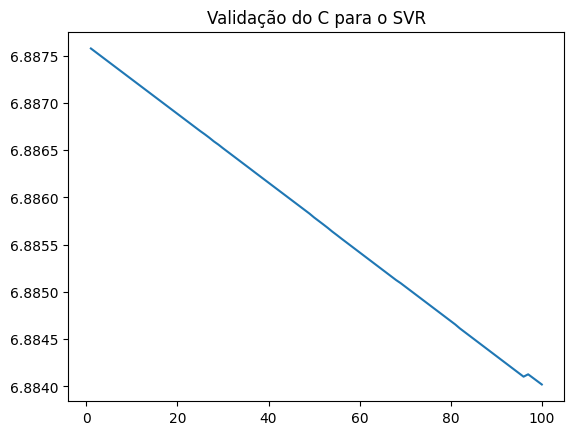

In [16]:
train_list = dict_train['Aguas_do_Vere']
x = train_list[:, :-1]
y = train_list[:, -1]

validate_list = np.array(df_validation.values.tolist())
x_validate = validate_list[:, :-1]
y_validate = validate_list[:, -1]

min_mse = math.inf
mses = []
for c in range (1, 101):
    model = svm.SVR(kernel='rbf', C=c)
    model.fit(x, y)
    pred = model.predict(x_validate)
    mse = mean_squared_error(y_validate, pred)
    if mse < min_mse:
        min_mse = mse
    
    mses.append(mse)

print(f'mse: {min_mse} - {mses.index(min_mse) + 1}')
x = range(1, len(mses) + 1)
y = mses

plt.title('Validação do C para o SVR')
plt.plot(x, y)
plt.show()

Validação do K para o Knn

mse: 6.232221295788638 - 41


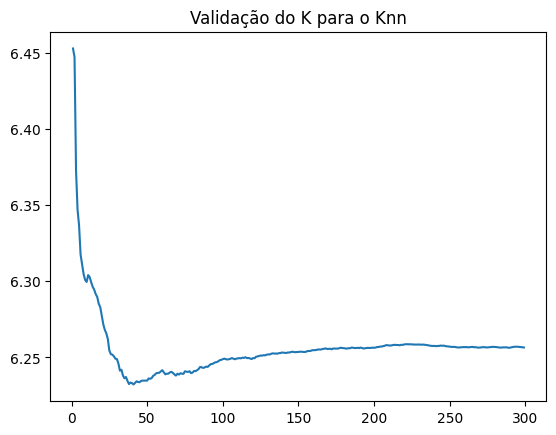

In [17]:
train_list = dict_train['Aguas_do_Vere']
x = train_list[:, :-1]
y = train_list[:, -1]

validate_list = np.array(df_validation.values.tolist())
x_validate = validate_list[:, :-1]
y_validate = validate_list[:, -1]

min_mse = math.inf
mses = []
for k in range (1, 300):
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(x, y)
    pred = model.predict(x_validate)
    mse = mean_squared_error(y_validate, pred)
    if mse < min_mse:
        min_mse = mse
    
    mses.append(mse)

print(f'mse: {min_mse} - {mses.index(min_mse) + 1}')
x = range(1, len(mses) + 1)
y = mses

plt.title('Validação do K para o Knn')
plt.plot(x, y)
plt.show()

Validação do Depth para o Tree Regressor

mse: 5.3441082471823425 - 3


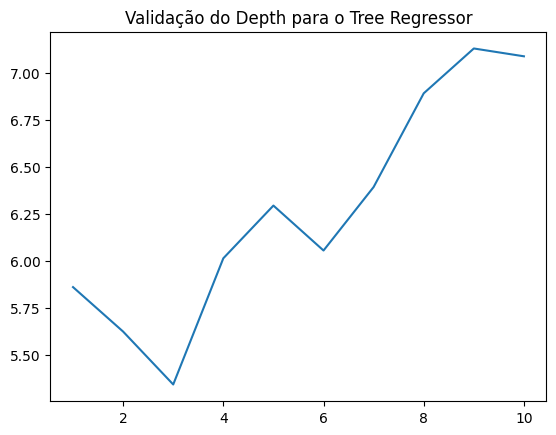

In [23]:
train_list = dict_train['Aguas_do_Vere']
x = train_list[:, :-1]
y = train_list[:, -1]

validate_list = np.array(df_validation.values.tolist())
x_validate = validate_list[:, :-1]
y_validate = validate_list[:, -1]

min_mse = math.inf
mses = []
for depth in range (1, 11):
    model = tree.DecisionTreeRegressor(max_depth=depth)
    model.fit(x, y)
    pred = model.predict(x_validate)
    mse = mean_squared_error(y_validate, pred)
    if mse < min_mse:
        min_mse = mse
    
    mses.append(mse)

print(f'mse: {min_mse} - {mses.index(min_mse) + 1}')
x = range(1, len(mses) + 1)
y = mses

plt.title('Validação do Depth para o Tree Regressor')
plt.plot(x, y)
plt.show()

### 7° Validaçao dos modelos de regressão

Validação dos 4 modelos de regressão utilizados:
- Linear Regression
- Tree Regresion
- SVR
- KNN

Com os resultados obtidos, uma nova clusterização da base de treinamento foi montada

Resultados:
- Validação dos modelos para construção dos clusters finais de dados para o treinamento dos modelos finais


In [19]:
df_validation_for_train = df_validation.copy()

Realizando o treinamento dos modelos e armazenando os valores das predições para calcular os erros e fazer comparações

In [20]:
def get_model(model):
    match model:
        case 'knn':
            return neighbors.KNeighborsRegressor(n_neighbors=48)
        case 'svr':
            return svm.SVR(kernel='rbf', C=100)
        case 'linear_regression':
            return linear_model.LinearRegression()
        case 'tree_regression':
            return tree.DecisionTreeRegressor(max_depth=4)

models = ['knn', 'svr', 'linear_regression', 'tree_regression']
est_preds = {}

validate_list = np.array(df_validation_for_train.values.tolist())
x_validate = validate_list[:, :-1]
y_validate = validate_list[:, -1]

for est in dict_train:
    train_list = dict_train[est]
    x_train = train_list[:, :-1]
    y_train = train_list[:, -1]

    preds = {}
    for model_type in models:
        model = get_model(model_type)
        model.fit(x_train, y_train)

        pred = model.predict(x_validate)
        preds[model_type] = pred

    est_preds[est] = preds

Construção de um dicionário armazenando os erros de predição para cada estação

In [21]:
errors = {}
for est in est_preds:
    est_errors = {}
    for model in est_preds[est]:
        mse = mean_squared_error(y_validate, est_preds[est][model])
        mae = mean_absolute_error(y_validate, est_preds[est][model])
        est_errors[model] = { 'mse': mse, 'mae': mae }
    errors[est] = est_errors

Construindo uma tabela de comparação para tomar decisões sobre os resultados obtidos

In [22]:
df_comparison = pd.DataFrame(columns=['Estação', 'Melhor Modelo MSE', 'MSE', 'Melhor Modelo MAE', 'MAE'])

for est in errors:
    min_mse = None
    min_mse_value = math.inf
    min_mae = None
    min_mae_value = math.inf

    for model in errors[est]:
        if errors[est][model]['mse'] < min_mse_value:
            min_mse = model
            min_mse_value = errors[est][model]['mse']
        if errors[est][model]['mae'] < min_mae_value:
            min_mae = model
            min_mae_value = errors[est][model]['mae']
    new_row = [est, min_mse, min_mse_value, min_mae, min_mae_value]
    df_comparison.loc[len(df_comparison)] = new_row

df_comparison

,Estação,Melhor Modelo MSE,MSE,Melhor Modelo MAE,MAE
0,Aguas_do_Vere,tree_regression,5.455154,tree_regression,0.938932
1,Altonia,tree_regression,5.955471,svr,1.009043
2,Assis_Chateaubriand,knn,6.191343,svr,1.006789
3,Baixo_Iguacu,tree_regression,5.950237,svr,1.008657
4,Bela_Vista_Jusante,knn,6.118092,svr,1.009135
5,Boa_Vista_da_Aparecida,linear_regression,5.683691,svr,1.007589
6,Campo_Mourao,tree_regression,5.638281,tree_regression,0.950041
7,Cascavel,knn,6.232197,svr,1.007951
8,Coronel_Domingos_Soares,tree_regression,6.130733,svr,1.012277
9,Derivacao_do_Rio_Jordao,knn,6.386385,svr,1.009154


### 8° Clusterização final da base de treinamento

Com os resultados obtidos na validação, a base de treinamento foi separado em 3 clustes:
- 1 Cluster para o tree Regressor
- 1 para o Knn Regressor
- 1 para o Linear Regressor

Resultados:
- Criação do dicionário *cluster_train* para o treinamento dos modelos finais

In [23]:
clusters = { 'knn': [], 'tree_regression': [], 'linear_regression': [] }
for row in df_comparison.iterrows():
    clusters[row[1]['Melhor Modelo MSE']].append(row[1]['Estação'])
    
cluster_train = {}

for cluster in clusters:
    group = dict_train[clusters[cluster][0]]
    for index in range(1, len(clusters[cluster])):
        group = np.concatenate((group, dict_train[clusters[cluster][index]]), axis=0)
    cluster_train[cluster] = group

### 9° validação do K e Depth para os regressores finais

Utilização de uma 'Cross validation' para testar valores de 1 a 300 de K e 1 a 10 para o depth, no intuito de encontrar o valor que minimiza o erro MSE para os modelos utilizando a base de validação

Resultados:
- O valor otimo para K
- O valor otimo de Depth

Busca do valor otimo de K

mse: 6.197569267521157 - 55


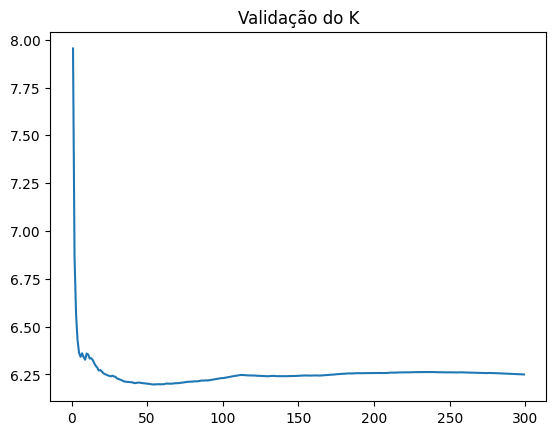

In [24]:
train_list = cluster_train['knn']
x = train_list[:, :-1]
y = train_list[:, -1]

validate_list = np.array(df_validation_for_train.values.tolist())
x_validate = validate_list[:, :-1]
y_validate = validate_list[:, -1]

min_mse = math.inf
mses = []
for k in range(1, 300):
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(x, y)
    pred = model.predict(x_validate)
    mse = mean_squared_error(y_validate, pred)
    if mse < min_mse:
        min_mse = mse

    mses.append(mse)

print(f'mse: {min_mse} - {mses.index(min_mse) + 1}')

x = range(1, len(mses) + 1)
y = mses

plt.title('Validação do K')
plt.plot(x, y)
plt.show()

Busca do valor otimo de Depth

mse: 5.404098929624166 - 6


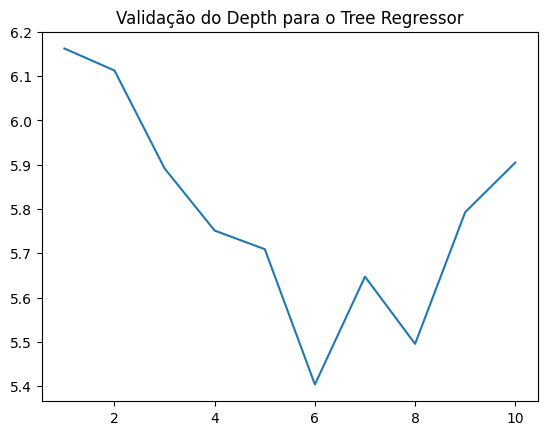

In [25]:
train_list = cluster_train['tree_regression']
x = train_list[:, :-1]
y = train_list[:, -1]

validate_list = np.array(df_validation_for_train.values.tolist())
x_validate = validate_list[:, :-1]
y_validate = validate_list[:, -1]

min_mse = math.inf
mses = []
for depth in range (1, 11):
    model = tree.DecisionTreeRegressor(max_depth=depth)
    model.fit(x, y)
    pred = model.predict(x_validate)
    mse = mean_squared_error(y_validate, pred)
    if mse < min_mse:
        min_mse = mse
    
    mses.append(mse)

print(f'mse: {min_mse} - {mses.index(min_mse) + 1}')
x = range(1, len(mses) + 1)
y = mses

plt.title('Validação do Depth para o Tree Regressor')
plt.plot(x, y)
plt.show()

### 9° Preparação da base de teste

Realização do Data Imputation na base de teste

Resultados:
- Base de teste com todas as linhas com valores preenchidos (*df_test*)

OBS: Não foi utilizado o KNN Imputation pois os dados deste Data Imputation são oriundo da base de treinamento, e não da própia base de validação


In [26]:
df_test = df_raw_test.drop(['time','Est', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1)

Realizando o input na base de teste

O input foi realizado por meio da busca do vizinho mais proximo em *Tp_est* na lista input_values

In [27]:
def get_fields_to_input(row, columns):
    fields = []
    for col in columns:
        if str(row[col]) == 'nan':
            fields.append(col)
    return fields

def get_data(tp_est, input_values):
    data = None
    min_distance = math.inf
    for value in input_values:
        distance = abs(tp_est - value["Tp_est"])
        if distance < min_distance:
            min_distance = distance
            data = value

    return data

columns = list(df_test.head())
for row in df_test.iterrows():

    fields_to_input = get_fields_to_input(row[1], columns)
    if len(fields_to_input) > 0:
        input_data = get_data(row[1]["Tp_est"], input_values)
        for field in fields_to_input:
            if str(row[1][field]) == 'nan':
                df_test.loc[row[0], field] = input_data[col]

### 10° Treinamento dos modelos finais

Resultado:
- 1 Modelo Tree Regressor
- 1 Modelo KNN Regressor
- 1 Modelo Linear Regressor

In [31]:
tree_regressor = tree.DecisionTreeRegressor(max_depth=7)
knn = neighbors.KNeighborsRegressor(n_neighbors=149)
linear = linear_model.LinearRegression()

tree_train = cluster_train['tree_regression']
knn_train = cluster_train['knn']
linear_train = cluster_train['linear_regression']

x_tree = tree_train[:, :-1]
y_tree = tree_train[:, -1]

x_knn = knn_train[:, :-1]
y_knn = knn_train[:, -1]

x_linear = linear_train[:, :-1]
y_linear = linear_train[:, -1]

tree_regressor.fit(x_tree, y_tree)
knn.fit(x_knn, y_knn)
linear.fit(x_linear, y_linear)

LinearRegression()

### 11° Predições e Resultados

Realização das predições finais para o modelo

Resultados:
- Metricas de erro MSE e MAE
- Gráfico de Dispersão


In [32]:
test_list = np.array(df_test.values.tolist())
x_test = test_list[:, :-1]
y_test = test_list[:, -1]

tree_pred = tree_regressor.predict(x_test)
knn_pred = knn.predict(x_test)
linear_pred = linear.predict(x_test)

final_pred = [a + b for a,b in zip(tree_pred, knn_pred)]
final_pred = [a + b for a,b in zip(final_pred, linear_pred)]
final_pred = [x / 3 for x in final_pred]

Cálculo e print das medidas de erro

In [33]:
mse = mean_squared_error(y_test, final_pred)
mae = mean_absolute_error(y_test, final_pred)

print(f'mse: {mse} - mae: {mae}')

mse: 3.7245458958043005 - mae: 0.9028447405820067


Construção do gráfico de dispersão

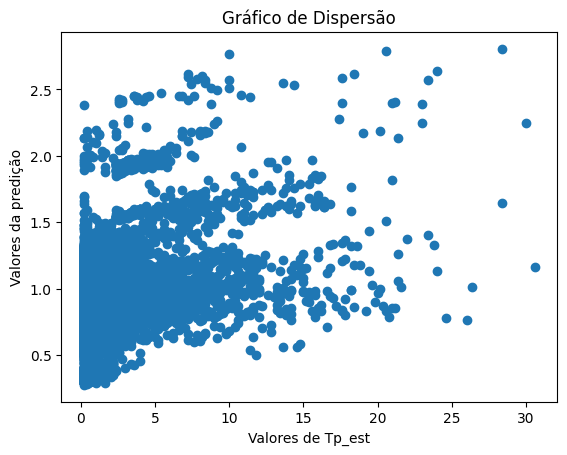

In [34]:
x = y_test
y = final_pred

plt.xlabel('Valores de Tp_est')
plt.ylabel('Valores da predição')
plt.title('Gráfico de Dispersão')
plt.scatter(x, y)
plt.show()